In [28]:
import os
import nltk
import pandas as pd
import numpy as np
from sklearn import preprocessing, pipeline, svm, linear_model, neighbors, metrics, ensemble
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
from nltk.stem import WordNetLemmatizer
from nltk import wordpunct_tokenize, WordNetLemmatizer, sent_tokenize, pos_tag
from nltk.corpus import stopwords as sw, wordnet as wn
import re
import string 
import copy
from unidecode import unidecode
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
dataPath = ".\\data"

In [5]:
import numpy as np
CUSTOM_SEED = 42
np.random.seed(CUSTOM_SEED)

In [29]:
stopwords = ["about", "all", "also", "among", "at", "available", "be", "because", "been", "both", "but", "by", "can", "each", "first", "has", "have", "here", "how",
             "however", "into", "it", "its", "large", "learn", "many", "may", "more", "most", "much", "new", "not", "often", "only", "or", "other", "over", "recent", "related", "same",
             "several", "shown", "some", "studies", "such", "than", "their", "them", "then", "there", "these", "they", "those", "through", "use", "used", "we", "well", "what",
             "when", "where", "which"]
def find_files(search_path):
    result = []
    # Walking top-down from the root
    for root, dir, files in os.walk(search_path):
        for file in files:       
                result.append(os.path.join(root, file))
    return result

def loadData(paths):
    data = pd.DataFrame(columns=["tokens", "label"])
    for i in paths:
        try:
            doc = pd.read_csv(i, sep="\t", names=["tokens", "label"], header=None)
            doc['file'] = i[12:-5]
            data = pd.concat([data, doc], ignore_index=True)
        except Exception as e: 
            print(i, e)
    return data

def stripSpaces(x):
    x = unidecode(x)
    specialchar = "!@#$%^&*()[]{};:,./<>?\|`-~=_+\t\n"
    for tag in specialchar:
        x = x.replace(tag, '')
    x = x.replace(" ", "")
    x = x.lower()
    x = x.strip()
    return x

def cleaning(_dataset, lemma=True, pos=False, verbose=True):
    dataset = _dataset.copy()
    dataset.drop(dataset[dataset["tokens"].isna()].index, inplace=True)
    if verbose: 
        print("Size after Dropping Null Tokens",dataset.shape)
        print("Tokens Without labels:")
    for indexWithNullLabel in dataset[dataset["label"].isna()].index:
        token = dataset["tokens"][indexWithNullLabel]
        #split with ' ' doesnt consider multiple spaces as one
        tokenslist = token.split()
        dataset["tokens"][indexWithNullLabel] = tokenslist[0]

        if (len(tokenslist) > 1):
            dataset["label"][indexWithNullLabel] = tokenslist[1]
        else:
            if verbose:
                print(dataset.loc[indexWithNullLabel, :])
            #Manual Correction for 5467 and 5858 (very & research)
            dataset["label"][indexWithNullLabel] = 'O'
            if verbose:
                print("Manual Corrected:", dataset["tokens"][indexWithNullLabel])
    dataset = dataset.applymap(stripSpaces)
    #label to handel 0, i*, b*, o*, 0*
    dataset[dataset["label"] == 'ii'] = 'i'
    dataset[dataset["label"] == '0'] = 'o'
    if verbose:
        print("Removing special characters")
    specialCharTokens = dataset[~(dataset["tokens"].str.isalnum())]["tokens"].unique()
    #for sprecialChar with label B, moving label to next row and droping rows  
    specialCharWithB = dataset[dataset["tokens"].isin(specialCharTokens) & (dataset["label"] == 'b')].index
    for i in specialCharWithB:
        dataset.loc[i+1, "label"] = 'b'
    dataset.drop(dataset[dataset["tokens"].isin(specialCharTokens) & ((dataset["label"] == 'o') | (dataset["label"] == 'b') )].index, inplace=True)
    #Drop i where there is i and b before it
    toDrop = []
    for i in dataset[dataset["tokens"].isin(specialCharTokens)].index:
        if(dataset["label"][i-1] == 'b' or dataset["label"][i-1] == 'i' ):
            toDrop.append(i)
        else:
            dataset["label"][i] = 'b'
    dataset.drop(toDrop, axis=0, inplace=True)
    if verbose:
        print(dataset.value_counts()[:30])
        print("Removing Stopwords based on above listed most frequent words")
    stopwords = ["the","this","that","has","have","can","be","in","on","at","to","as","is","are","a","an","with","our","we","from","which","when","also","and","or","not","it","its",
                 "than","use","into","how","but","to","for","their","there","all"]
    if verbose:
        print("Label order correction:")
    dataset.reset_index(drop=True, inplace=True)
    temp = dataset.copy()
    temp["before"] = temp["label"].shift(1)
    temp["after"] = temp["label"].shift(-1)
    for i in temp[(temp["label"] == 'i') & (temp["before"] == 'o') ].index:
            # oio or oii
            if verbose:
                print(temp.loc[i-1, "tokens"]+"("+temp.loc[i-1, "label"]+")\t\t", temp.loc[i, "tokens"]+"("+temp.loc[i, "label"]+")\t\t", temp.loc[i+1, "tokens"]+"("+temp.loc[i+1, "label"]+")")
            if(temp.loc[i+1, "label"] == 'o' or temp.loc[i+1, "label"] == 'i'):
                dataset.loc[i, "label"] = 'b'
            # oib
            if(temp.loc[i+1, "label"] == 'b'):
                dataset.loc[i, "label"] = 'b'
                dataset.loc[i+1, "label"] = 'i'
    del temp
    if verbose:
        print(dataset[(dataset["tokens"].isin(stopwords))]["tokens"].value_counts().index)
    dataset.drop(dataset[dataset["tokens"].isin(dataset)].index, inplace=True)
    if pos:
        dataset["POS"] = nltk.pos_tag(train["tokens"])
    if lemma:
        lemmatizer = WordNetLemmatizer()
        dataset["tokens"] = dataset["tokens"].apply(lambda x: lemmatizer.lemmatize(x))
    dataset.reset_index(drop=True, inplace=True)
    return dataset

def featurePreparation(_dataset, ref=1):
    dataset = _dataset.copy()
    if  ref == 0:
        dataset["text"] = dataset["tokens"]
    elif ref == 1:
        dataset["text"] = dataset["tokens"].shift(fill_value= "") + " " + dataset["tokens"] \
                            + " " + dataset["tokens"].shift(-1, fill_value= "")
    elif ref == 2:
        dataset["text"] = dataset["tokens"].shift(2, fill_value= "") + " " + dataset["tokens"].shift(fill_value= "") \
                            + " " + dataset["tokens"] + " " + dataset["tokens"].shift(-1, fill_value= "") \
                            + " " + dataset["tokens"].shift(-2, fill_value= "")
    elif ref == 3:
        dataset["text"] = dataset["tokens"].shift(3, fill_value= "") + " " + dataset["tokens"].shift(2, fill_value= "") \
                            + " " + dataset["tokens"].shift(fill_value= "") + " " + dataset["tokens"] \
                            + " " + dataset["tokens"].shift(-1, fill_value= "") \
                            + " " + dataset["tokens"].shift(-2, fill_value= "") + " " + dataset["tokens"].shift(-3, fill_value= "")
    dataset["text"] = dataset["tokens"]
    dataset = dataset.drop(["tokens", "file"], axis=1)
    return dataset

def pre_pipeline(ref=1, pos=False,lemma=True):
    trainFiles = find_files(dataPath + "\\train")
    testFiles = find_files(dataPath + "\\test")
    devFiles = find_files(dataPath + "\\dev")
    train = loadData(trainFiles)
    test  = loadData(testFiles)
    dev = loadData(devFiles)
    train = cleaning(train, lemma=lemma, pos=pos, verbose=False)
    test = cleaning(test, lemma=lemma, pos=pos, verbose=False)
    dev = cleaning(dev, lemma=lemma, pos=pos, verbose=False)
    train = featurePreparation(train, ref=ref)
    test = featurePreparation(test, ref=ref)
    dev = featurePreparation(dev, ref=ref)
    return train, test, dev

In [47]:
train, test, dev = pre_pipeline(lemma=False)
vectorizer = CountVectorizer()
trainX = vectorizer.fit_transform(train["text"])
testX = vectorizer.transform(test["text"])
devX = vectorizer.transform(dev["text"])
print("Vobac Size", len(vectorizer.get_feature_names_out()))

le = preprocessing.OneHotEncoder()
le = le.fit(train["label"].values.reshape(-1,1))
trainY = le.transform(train["label"].values.reshape(-1,1))
devY = le.transform(dev["label"].values.reshape(-1,1))
testY = le.transform(test["label"].values.reshape(-1,1))

Vobac Size 2980


In [49]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

def build_model(input_dim, hidden_neurons, output_dim):
    """
    Construct, compile and return a Keras model which will be used to fit/predict
    """
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [149]:
from keras.wrappers.scikit_learn import KerasClassifier
model_params = {
    'build_fn': build_model,
    'input_dim': trainX.shape[1],
    'hidden_neurons': 512,
    'output_dim': trainY.shape[1],
    'epochs': 14,
    'batch_size': 3000,
    'verbose': 1,
    'validation_data': (devX.toarray(), devY.toarray()),
    'shuffle': True
}
clf = KerasClassifier(**model_params)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23064\3618872089.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(**model_params)


In [150]:
hist = clf.fit(trainX.toarray(), trainY.toarray())

Epoch 1/14
7/7 [==============================] - 2s 167ms/step - loss: 0.9955 - accuracy: 0.6442 - val_loss: 0.8034 - val_accuracy: 0.7590
Epoch 2/14
7/7 [==============================] - 1s 120ms/step - loss: 0.7380 - accuracy: 0.7388 - val_loss: 0.6516 - val_accuracy: 0.7590
Epoch 3/14
7/7 [==============================] - 1s 120ms/step - loss: 0.6593 - accuracy: 0.7388 - val_loss: 0.5927 - val_accuracy: 0.7590
Epoch 4/14
7/7 [==============================] - 1s 125ms/step - loss: 0.5745 - accuracy: 0.7388 - val_loss: 0.5632 - val_accuracy: 0.7590
Epoch 5/14
7/7 [==============================] - 1s 120ms/step - loss: 0.5276 - accuracy: 0.7388 - val_loss: 0.5374 - val_accuracy: 0.7590
Epoch 6/14
7/7 [==============================] - 1s 123ms/step - loss: 0.4868 - accuracy: 0.7388 - val_loss: 0.5202 - val_accuracy: 0.7590
Epoch 7/14
7/7 [==============================] - 1s 133ms/step - loss: 0.4585 - accuracy: 0.7388 - val_loss: 0.5148 - val_accuracy: 0.7590
Epoch 8/14
7/7 [====

In [152]:
import matplotlib.pyplot as plt

def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """    
    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'    # plot model loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')    # plot model accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, green, linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', color=orange, fontweight='bold')

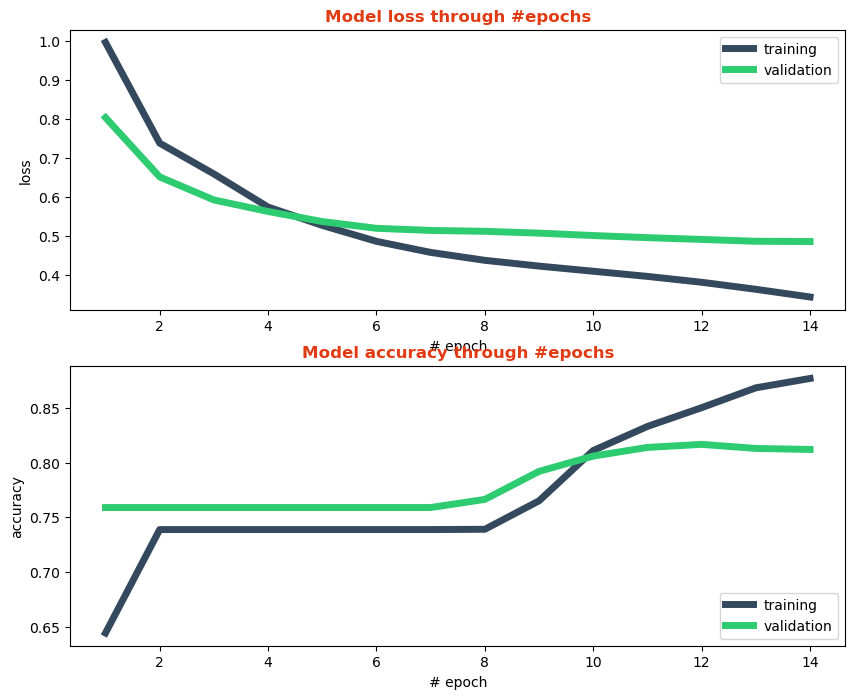

In [161]:
plot_model_performance(
    train_loss=hist.history.get('loss', []),
    train_acc=hist.history.get('accuracy', []),
    train_val_loss=hist.history.get('val_loss', []),
    train_val_acc=hist.history.get('val_accuracy', [])
)

In [154]:
score = clf.score(testX.toarray(), testY.toarray())
print(score)

1/1 [==============================] - 0s 283ms/step - loss: 0.5141 - accuracy: 0.8041
0.8040650486946106


In [155]:
from keras.utils import plot_model
plot_model(clf.model, to_file='model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [157]:
clf.model.save('./keras_mlp.h5')

In [162]:
yhat = clf.predict(testX.toarray())

77/77 [==============================] - 0s 3ms/step


In [192]:
# 0=b 1=i 2=o
yhat = pd.DataFrame(yhat)
yhat[yhat[0] == 0]  = 'b'
yhat[yhat[0] == 1]  = 'i'
yhat[yhat[0] == 2]  = 'o'

In [200]:
d = {'y': test["label"].values, 'yhat': yhat[0].values}
comparison = pd.DataFrame(data=d)

In [202]:
# comparison[(comparison["y"] == 'o') & (comparison["yhat"] != 'o')].shape
comparison[comparison["y"] != 'o']

,y,yhat
3,b,b
4,i,i
6,b,b
7,b,i
14,b,b
...,...,...
2421,i,o
2422,i,i
2450,b,i
2451,i,o


In [255]:
spanEval = pd.DataFrame( columns=["y", "yhat"])
for i in range(0, comparison.shape[0]):
    if(comparison['y'][i] == 'b'):
        j = i+1
        ystr = "b"
        yhatstr = comparison['yhat'][i]
        while(comparison['y'][j] == "i"):
            ystr = ystr + comparison['y'][j]
            yhatstr = yhatstr + comparison['yhat'][j]
            j = j + 1
        toAppend = pd.DataFrame({'y':ystr, 'yhat':yhatstr}, index={1})
        spanEval = pd.concat([spanEval, toAppend], ignore_index=True)

In [271]:
spanEval[(spanEval['y'] == spanEval['yhat'])].shape[0] / spanEval.shape[0]

0.19875776397515527

In [266]:
spanEval[(spanEval['y'] == spanEval['yhat']) & (spanEval['yhat'].str.len() == 2)].shape[0] / spanEval[(spanEval['yhat'].str.len() == 2)].shape[0]

0.2463768115942029

In [268]:
spanEval[(spanEval['y'] == spanEval['yhat']) & (spanEval['yhat'].str.len() == 1)].shape[0] / spanEval[(spanEval['yhat'].str.len() == 1)].shape[0]

0.27184466019417475

In [269]:
spanEval[(spanEval['y'] == spanEval['yhat']) & (spanEval['yhat'].str.len() == 3)].shape[0] / spanEval[(spanEval['yhat'].str.len() == 3)].shape[0]

0.029411764705882353